In [21]:
import sqlite3
import datetime
import pandas as pd

# 连接到 SQLite 数据库
conn = sqlite3.connect('/kaggle/input/bitcoin-data/bitcoin_data.db')
cursor = conn.cursor()

# 执行 SQL 查询
query_1m = f"SELECT * FROM bitcoin_data_1m"
# query_3m = f"SELECT * FROM bitcoin_data_3m"
# query_5m = f"SELECT * FROM bitcoin_data_5m"
# query_15m = f"SELECT * FROM bitcoin_data_15m"

# 获取查询结果-df格式
data_1m = pd.read_sql(query_1m, conn)
# data_3m = pd.read_sql(query_3m, conn)
# data_5m = pd.read_sql(query_5m, conn)
# data_15m = pd.read_sql(query_15m, conn)

# 关闭数据库连接
conn.close()

In [22]:
def process_timestamp(df, timestamp_col='Open_time'):
    """
    处理时间戳列：
    1. 将时间戳列转换为字符串，检查长度。
    2. 若长度为16（毫秒级时间戳），则转为秒级（除以1000）。
    3. 最终确保时间戳为整数类型。
    """
    # 转换为字符串检查长度
    df[timestamp_col] = df[timestamp_col].astype(str)
    
    # 处理时间戳（毫秒转秒）
    df[timestamp_col] = df[timestamp_col].apply(
        lambda x: int(x) // 1000 if len(x) == 16 else int(x)
    )
    
    # 确保为整数类型
    df[timestamp_col] = df[timestamp_col].astype(int)
    df[timestamp_col] = pd.to_datetime(df[timestamp_col], unit='ms')
    return df

data_1m = process_timestamp(data_1m)

In [23]:
df_train = data_1m[(data_1m['Open_time'] >= '2022-01-01 00:00:00') & (data_1m['Open_time'] < '2025-01-01 00:00:00')]
df_test = data_1m[(data_1m['Open_time'] >= '2025-01-01 00:00:00') & (data_1m['Open_time'] < '2025-05-01 00:00:00')]

### 特征获取

In [4]:
import pandas as pd
import numpy as np

def calc_sma_diff(close, timeperiod_short, timeperiod_long):
    res_short = close[-timeperiod_short:].mean()
    res_long = close[-timeperiod_long:].mean()
    res = (res_long - res_short) / res_long
    return res

def calc_bbands(close, timeperiod, std=2):
    close_std = close[-timeperiod:].std(ddof=0)
    rol = close[-timeperiod:].mean()
    upper = rol + close_std * std
    lower = rol - close_std * std
    res = (upper - close[-1]) / (upper - lower)
    return res

def calc_rsi(close, timeperiod):
    diff = np.diff(close[-(timeperiod+1):])
    A = diff[diff>0].sum() / timeperiod
    B = -diff[diff<0].sum() / timeperiod
    rsi = 100 * A / (A + B)
    return rsi

def calc_atr(high, low, close, timeperiod):
    A = high[-timeperiod:] - close[-(timeperiod+1):-1]
    B = close[-(timeperiod+1):-1] - low[-timeperiod:]
    C = high[-timeperiod:] - low[-timeperiod:]
    res = np.vstack((A, B, C)).max(axis=0).mean()
    return res

def calc_natr(high, low, close, timeperiod):
    res = calc_atr(high, low, close, timeperiod) / close[-1]
    return res

def calc_minus_di(high, low, close, timeperiod):
    high_diff = np.diff(high[-(timeperiod+1):])
    low_diff = np.diff(low[-(timeperiod+1):])
    high_diff[(high_diff<0)] = 0
    low_diff[(low_diff<0)] = 0
    low_diff[(high_diff>low_diff)] = 0
    tr = calc_atr(high, low, close, timeperiod)*timeperiod
    res = 100 * low_diff.sum() / tr
    return res

def calc_plus_di(high, low, close, timeperiod):
    high_diff = np.diff(high[-(timeperiod+1):])
    low_diff = np.diff(low[-(timeperiod+1):])
    high_diff[(high_diff<0)] = 0
    low_diff[(low_diff<0)] = 0
    high_diff[(high_diff<low_diff)] = 0
    tr = calc_atr(high, low, close, timeperiod)*timeperiod
    res = 100 * high_diff.sum() / tr
    return res

def calc_log_ret(close, lag=0):
    return np.log(close[-(1+15*lag)] / close[-(1+15*(lag+1))])

def upper_shadow_15_perc(high, close, open_, lag=0):
    if lag:
        return high[-15*(lag+1):-15*lag].max() * 100 / np.maximum(close[-15*lag-1], open_[-15*(lag+1)-1])
    else:
        return high[-15:].max() * 100 / np.maximum(close[-1], open_[-16])

def lower_shadow_15_perc(low, close, open_, lag=0):
    if lag:
        return np.minimum(close[-15*lag-1], open_[-15*(lag+1)-1]) * 100 / low[-15*(lag+1):-15*lag].min()
    else:
        return np.minimum(close[-1], open_[-16]) * 100 / low[-15:].min()

# 主动买入相关
def taker_buy_ratio_base(volume, taker_buy_base_asset_volume, window=15):
    vol = volume[-window:].sum()
    buy = taker_buy_base_asset_volume[-window:].sum()
    return buy / vol if vol > 0 else 0

def taker_buy_ratio_quote(quote_asset_volume, taker_buy_quote_asset_volume, window=15):
    vol = quote_asset_volume[-window:].sum()
    buy = taker_buy_quote_asset_volume[-window:].sum()
    return buy / vol if vol > 0 else 0

def taker_buy_strength_diff(taker_buy_base_asset_volume, short=15, long=60):
    short_mean = taker_buy_base_asset_volume[-short:].mean()
    long_mean = taker_buy_base_asset_volume[-long:].mean()
    return short_mean - long_mean

In [5]:
def get_features(df, open_, high, low, close, volume, 
                 quote_asset_volume, taker_buy_base_asset_volume, taker_buy_quote_asset_volume):
    # close: 当前行向前一共 row_num = 24*4*4*4*4 + 50 行，最后一行就是当前行
    res = []
    res.append(calc_sma_diff(close, 12, 26))
    res.append(calc_sma_diff(close, 12*4*4, 24*4*4))
    res.append(calc_sma_diff(close, 12*4*4*4, 24*4*4*4))
    res.append(calc_sma_diff(close, 12*4*4*4*4, 24*4*4*4*4))
    res.append(calc_sma_diff(volume, 12*4*4, 24*4*4))
    res.append(calc_rsi(close, 14*4))
    res.append(calc_natr(high, low, close, 14*4*4*4))
    res.append(calc_minus_di(high, low, close, 14))
    res.append(calc_minus_di(high, low, close, 14*4*4*4))
    res.append(calc_plus_di(high, low, close, 14*4))
    res.append(calc_plus_di(high, low, close, 14*4*4*4))
    res.append(calc_log_ret(close))
    res.append(calc_log_ret(close, lag=1))
    res.append(calc_log_ret(close, lag=2))
    res.append(upper_shadow_15_perc(high, close, open_))
    res.append(lower_shadow_15_perc(low, close, open_))
    res.append(calc_bbands(close, 5*4*2))
    res.append(calc_bbands(close, 5*4*4))
    res.append(calc_bbands(close, 5*4*4*2))
    res.append(calc_bbands(close, 5*4*4*4))
    # 主动买入特征
    res.append(taker_buy_ratio_base(volume, taker_buy_base_asset_volume, window=15))
    res.append(taker_buy_ratio_quote(quote_asset_volume, taker_buy_quote_asset_volume, window=15))
    res.append(taker_buy_strength_diff(taker_buy_base_asset_volume, short=15, long=60))
    
    return res

In [8]:
def extract_features(df):
    
    return get_features(
        df,
        df["Open"].values,
        df["High"].values,
        df["Low"].values,
        df["Close"].values,
        df["Volume"].values,
        df["Quote_asset_volume"].values,
        df["Taker_buy_base_asset_volume"].values,
        df["Taker_buy_quote_asset_volume"].values
    )
    
def get_dataset_features(df):
    row_num = 24*4*4*4*4 + 50
    feature_names = [f'feature{i+1}' for i in range(23)]
    idx = 0

    # 用于收集所有样本
    records = []
    import tqdm
    for date, _ in tqdm.tqdm(df.iterrows()):
        if idx < row_num:
            idx += 1
            continue
        current_index = idx
        start_index = max(0, current_index - row_num)
        new_df = df.iloc[start_index:current_index + 1].copy()

        idx += 1
        features = extract_features(new_df)
        records.append([date] + list(features))

    final_feature_df = pd.DataFrame(records, columns=['idx'] + feature_names)
    return final_feature_df
    
final_feature_df_train = get_dataset_features(df_train)
final_feature_df_test = get_dataset_features(df_test)
# final_feature_df = get_dataset_features(data_1m)


644364it [18:55, 597.41it/s]/tmp/ipykernel_31/93982887.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  res = 100 * low_diff.sum() / tr
/tmp/ipykernel_31/93982887.py:43: RuntimeWarning: invalid value encountered in scalar divide
  res = 100 * low_diff.sum() / tr
/tmp/ipykernel_31/93982887.py:15: RuntimeWarning: invalid value encountered in scalar divide
  res = (upper - close[-1]) / (upper - lower)
/tmp/ipykernel_31/93982887.py:22: RuntimeWarning: invalid value encountered in scalar divide
  rsi = 100 * A / (A + B)
/tmp/ipykernel_31/93982887.py:53: RuntimeWarning: invalid value encountered in scalar divide
  res = 100 * high_diff.sum() / tr
1578160it [47:15, 556.53it/s]
129600it [03:37, 595.82it/s]


### 三分类

In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

In [ ]:
def construct_labels(df, horizon=15, threshold=0.00015):
    """
    构造三分类标签：
    - 未来收益率 > threshold      → 2(上涨)
    - 未来收益率 < -threshold     → 0(下跌)
    - 其余                       → 1(震荡)
    
    参数：
    - horizon: 向后看的分钟数
    - threshold: 涨跌阈值（例如 0.001 = 0.1%）
    """
    df = df.copy()
    df["future_return"] = np.log(df["Close"].shift(-horizon) / df["Close"])
    
    df["label"] = 1
    df.loc[df["future_return"] > threshold, "label"] = 2
    df.loc[df["future_return"] < -threshold, "label"] = 0
    
    return df

# 添加标签
df_train_labeled = construct_labels(df_train)
df_test_labeled = construct_labels(df_test)

df_train_labeled.dropna(subset=["future_return"], inplace=True)
df_test_labeled.dropna(subset=["future_return"], inplace=True)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


In [54]:
# 把标签 merge 回特征数据上，按时间对齐
final_feature_df_train = final_feature_df_train.merge(
    df_train_labeled["label"],
    left_on="idx",
    right_index=True,
    how="left"
)

final_feature_df_test = final_feature_df_test.merge(
    df_test_labeled["label"],
    left_on="idx",
    right_index=True,
    how="left"
)

# 去掉有缺失标签的样本（因为shift后的最后15分钟没有标签）
final_feature_df_train.dropna(subset=["label"], inplace=True)
final_feature_df_test.dropna(subset=["label"], inplace=True)


In [55]:
import lightgbm as lgb
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

X_train = final_feature_df_train.drop(columns=["idx", "label"])
y_train = final_feature_df_train["label"].astype(int)

X_test = final_feature_df_test.drop(columns=["idx", "label"])
y_test = final_feature_df_test["label"].astype(int)

train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# 2. 设置参数（多分类）
params = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': 3,
    'boosting_type': 'gbdt',
    'num_leaves': 100,
    'learning_rate': 0.01,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 1,
    'seed': 42,
    'n_jobs': -1
}

# 3. 训练模型
bst = lgb.train(
    params,
    train_data,
    num_boost_round=500,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

# 4. 预测（返回概率矩阵，形状 [n_samples, 3]）
y_pred_prob = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred_labels = np.argmax(y_pred_prob, axis=1)  # 取概率最大的类别


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5865
[LightGBM] [Info] Number of data points in the train set: 1571951, number of used features: 23
[LightGBM] [Info] Start training from score -0.786778
[LightGBM] [Info] Start training from score -2.480838
[LightGBM] [Info] Start training from score -0.774319
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[475]	valid_0's multi_logloss: 0.886406


              precision    recall  f1-score   support

   Down (-1)       0.48      0.50      0.49     57807
 Neutral (0)       0.14      0.00      0.00      8335
      Up (1)       0.48      0.53      0.50     57249

    accuracy                           0.48    123391
   macro avg       0.37      0.34      0.33    123391
weighted avg       0.46      0.48      0.46    123391



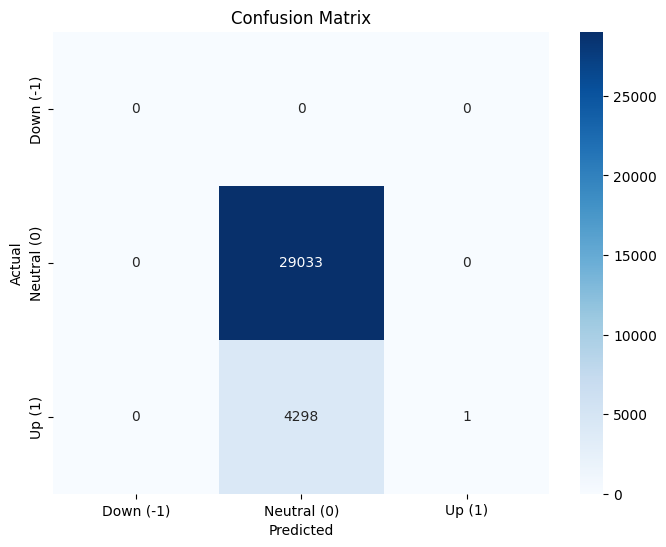

In [56]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(y_true, y_pred):
    """
    评估三分类模型性能，并绘制混淆矩阵
    
    参数:
    y_true -- 真实标签（0, 1, 2）
    y_pred -- 预测标签（0, 1, 2）
    """
    # 将 0,1,2 映射回 -1,0,1（如果原始标签是 -1,0,1）
    y_true_mapped = y_true.map({0: -1, 1: 0, 2: 1}) if isinstance(y_true, pd.Series) else y_true
    y_pred_mapped = y_pred.map({0: -1, 1: 0, 2: 1}) if isinstance(y_pred, pd.Series) else y_pred
    
    # 打印分类报告（精确率、召回率、F1等）
    print(classification_report(y_true_mapped, y_pred_mapped, target_names=['Down (-1)', 'Neutral (0)', 'Up (1)']))
    
    # 绘制混淆矩阵
    cm = confusion_matrix(y_true_mapped, y_pred_mapped, labels=[-1, 0, 1])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Down (-1)', 'Neutral (0)', 'Up (1)'], 
                yticklabels=['Down (-1)', 'Neutral (0)', 'Up (1)'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
# 5. 评估
y_test_true = y_test.to_numpy()
evaluate_model(y_test_true, y_pred_labels)

In [57]:
# 获取标签
returns_df = final_feature_df_test[['idx', 'label']].copy()
returns_df['pedict_label'] = y_pred_labels

# 获取收益率
df_test_returns = df_test[['Open_time', 'Close']].copy()
df_test_returns['pct'] = df_test_returns["Close"].shift(-15) / df_test_returns["Close"] - 1
# df_test_returns['pct'] = np.log(df_test_returns["Close"].shift(-15) / df_test_returns["Close"])

close_values = df_test_returns.loc[returns_df['idx']]['pct'].values
returns_df['pct'] = close_values
returns_df

,idx,label,pedict_label,pct
0,3876753,0.0,0,-0.000366
1,3876754,0.0,0,-0.000331
2,3876755,0.0,0,-0.000326
3,3876756,0.0,0,-0.000600
4,3876757,0.0,0,-0.000600
...,...,...,...,...
123386,4000139,2.0,2,0.000516
123387,4000140,2.0,2,0.001011
123388,4000141,2.0,2,0.000975
123389,4000142,2.0,2,0.001076


In [58]:

returns_df['predict_signal'] = 0

# 遍历DataFrame，根据predict_label的值设置predict_signal
for i in range(1, len(returns_df)):
    if returns_df.loc[i, 'pedict_label'] == 1:
        # 如果predict_label为1，则取上一行的predict_signal值
        returns_df.loc[i, 'predict_signal'] = returns_df.loc[i - 1, 'predict_signal']
    else:
        returns_df.loc[i, 'predict_signal'] = returns_df.loc[i - 1, 'pedict_label']

returns_df

,idx,label,pedict_label,pct,predict_signal
0,3876753,0.0,0,-0.000366,0
1,3876754,0.0,0,-0.000331,0
2,3876755,0.0,0,-0.000326,0
3,3876756,0.0,0,-0.000600,0
4,3876757,0.0,0,-0.000600,0
...,...,...,...,...,...
123386,4000139,2.0,2,0.000516,2
123387,4000140,2.0,2,0.001011,2
123388,4000141,2.0,2,0.000975,2
123389,4000142,2.0,2,0.001076,2


In [59]:
# 总收益率
returns_df['adjusted_true_returns'] = returns_df.apply(
    lambda row: (1 + row['pct']) if row['predict_signal'] > 0 else 1, axis=1
)

# 查看修改后的 DataFrame
returns_df

,idx,label,pedict_label,pct,predict_signal,adjusted_true_returns
0,3876753,0.0,0,-0.000366,0,1.000000
1,3876754,0.0,0,-0.000331,0,1.000000
2,3876755,0.0,0,-0.000326,0,1.000000
3,3876756,0.0,0,-0.000600,0,1.000000
4,3876757,0.0,0,-0.000600,0,1.000000
...,...,...,...,...,...,...
123386,4000139,2.0,2,0.000516,2,1.000516
123387,4000140,2.0,2,0.001011,2,1.001011
123388,4000141,2.0,2,0.000975,2,1.000975
123389,4000142,2.0,2,0.001076,2,1.001076


In [60]:
returns_df['adjusted_true_returns'].prod()

0.26133091752990484

In [61]:
bst.save_model('model_three_categories.txt')